In [2]:
import numpy as np

import argopandas as argo
import bgcArgoDMQC as bgc
from deconv import deconv_master as deconv

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks', palette='colorblind')

In [3]:
# grab floats with MTIME and DOXY measurements, load one
# ix = argo.bio_prof.subset_parameter('MTIME').subset_parameter('DOXY')
ix = argo.float(6900890).bio_prof.subset_parameter('MTIME').subset_parameter('DOXY')
data = ix.levels[['MTIME', 'PRES', 'TEMP_DOXY', 'DOXY', 'DOXY_QC']]
data = data[data.MTIME.notna()]
data = data[data.DOXY.notna()]

# reverse all the arrays so they are forward in time rather than pressure, convert time to seconds
time  = (data.MTIME[::-1].values - data.MTIME.min())*60*60*24
obs   = data.DOXY[::-1].values
pres  = data.PRES[::-1].values
temp  = data.TEMP_DOXY[::-1].values
data

Reading 256 files                                                     


MTIME  \
file                                       N_PROF N_LEVELS             
coriolis/6900890/profiles/BR6900890_001.nc 1      0         0.001470   
                                                  1         0.001343   
                                                  2         0.001215   
                                                  3         0.001088   
                                                  4         0.000961   
...                                                              ...   
coriolis/6900890/profiles/BR6900890_259.nc 1      148      -0.234711   
                                                  149      -0.239965   
                                                  150      -0.244942   
                                                  151      -0.249884   
                                                  152      -0.255903   

                                                                   PRES  \
file                                       N_PROF N_LEVELS                
coriolis/6900890/profiles/BR6900890_001.nc 1      0            0.200000   
                                                  1            0.230000   
                                                  2            0.230000   
                                                  3            0.060000   
                                                  4            0.160000   
...                                                                 ...   
coriolis/6900890/profiles/BR6900890_259.nc 1      148       1750.160034   
                                                  149       1800.250000   
                                                  150       1849.650024   
                                                  151       1898.560059   
                                                  152       1949.079956   

                                                            TEMP_DOXY  \
file                                       N_PROF N_LEVELS              
coriolis/6900890/profiles/BR6900890_001.nc 1      0         28.919001   
                                                  1         28.917999   
                                                  2         28.920000   
                                                  3         28.914000   
                                                  4         28.917000   
...                                                               ...   
coriolis/6900890/profiles/BR6900890_259.nc 1      148        3.822000   
                                                  149        3.773000   
                                                  150        3.725000   
                                                  151        3.663000   
                                                  152        3.591000   

                                                                  DOXY DOXY_QC  
file                                       N_PROF N_LEVELS                      
coriolis/6900890/profiles/BR6900890_001.nc 1      0         200.781342    b'4'  
                                                  1         200.806366    b'4'  
                                                  2         200.591003    b'4'  
                                                  3         200.719910    b'3'  
                                                  4         200.701614    b'3'  
...                                                                ...     ...  
coriolis/6900890/profiles/BR6900890_259.nc 1      148       222.911819    b'3'  
                                                  149       225.234756    b'3'  
                                                  150       227.532623    b'3'  
                                                  151       229.296982    b'3'  
                                                  152       231.594711    b'3'  

[39273 rows x 5 columns]

c:\Users\GordonC\Documents\projects\admt-doxy-correction\notebooks\dolvan-deconv-argo-test\deconv.py:642: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if sigma == 'auto':
c:\Users\GordonC\Documents\projects\admt-doxy-correction\notebooks\dolvan-deconv-argo-test\deconv.py:230: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  xhat=n.linalg.lstsq(A,m_v)[0]


Number of model points=10 fit residual norm 20583607.41 norm of solution second difference 106239.16 dt=225815040.00 (seconds)
Number of model points=11 fit residual norm 18699323.93 norm of solution second difference 124212.36 dt=205286400.00 (seconds)
Number of model points=14 fit residual norm 16235960.21 norm of solution second difference 123228.15 dt=161296457.15 (seconds)
Number of model points=16 fit residual norm 15820328.69 norm of solution second difference 135163.71 dt=141134400.00 (seconds)
Number of model points=20 fit residual norm 16045292.82 norm of solution second difference 135891.48 dt=112907520.00 (seconds)
Number of model points=24 fit residual norm 16378260.52 norm of solution second difference 133405.08 dt=94089600.00 (seconds)
Number of model points=28 fit residual norm 15997981.54 norm of solution second difference 128704.85 dt=80648228.57 (seconds)
Number of model points=34 fit residual norm 14981403.70 norm of solution second difference 122531.53 dt=66416188.

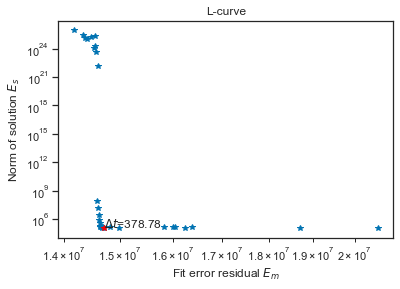

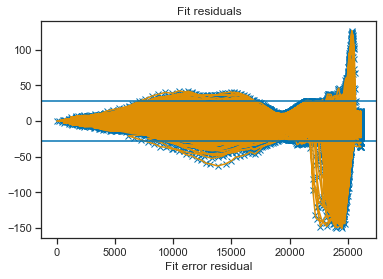

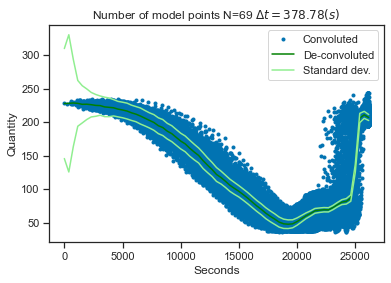

In [6]:
# get tau values from temperature
boundary_layer_thickness = 120
tau = bgc.lookup_tau(boundary_layer_thickness, temp)
k = 1/tau

# correct oxygen with Bittig method
bittig_corr = bgc.correct_response_time(time/60/60/24, obs, temp, boundary_layer_thickness)
# correct with Dolvan method
u_a_est, u_m_est, t_model, u_a_std, resid = deconv(obs, time, k[0], sigma=data.DOXY.std()*np.ones(time.shape))

(0.0, 300.0)

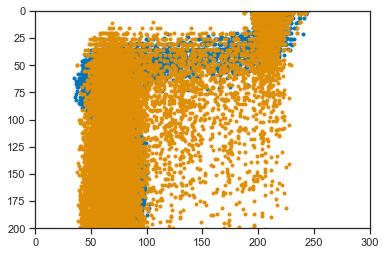

In [8]:
fig, axes = plt.subplots()
axes.plot(obs, pres, '.')
axes.plot(bittig_corr, pres, '.')
axes.set_ylim((200,0))
axes.set_xlim((0,300))

58.665905